# CNN for FCAL Shower Regression




## Prepare Dataset

In [1]:
%pip install h5py scikit-learn torch torchvision tqdm safetensors > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from urllib.parse import urlparse
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Custom TQDM progress bar for urllib downloads."""
    def update_to(self, blocks=1, block_size=1, total_size=None):
        """
        Update the progress bar.

        Args:
            blocks (int): Number of blocks transferred so far.
            block_size (int): Size of each block (in bytes).
            total_size (int, optional): Total size of the file (in bytes).
        """
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)


def download(url, target_dir):
    """
    Download a file from a URL into the target directory with progress display.

    Args:
        url (str): Direct URL to the file.
        target_dir (str): Directory to save the file.

    Returns:
        str: Path to the downloaded (or existing) file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Infer the filename from the URL
    filename = os.path.basename(urlparse(url).path)
    local_path = os.path.join(target_dir, filename)

    # If file already exists, skip download
    if os.path.exists(local_path):
        print(f"✅ File already exists: {local_path}")
        return local_path

    # Download with progress bar
    print(f"⬇️  Downloading {filename} from {url}")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=local_path, reporthook=t.update_to)

    print(f"✅ Download complete: {local_path}")
    return local_path

In [3]:

dataset_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_GUN_PATCHSIZE_11.h5"
data_dir = "data"
dataset_path = download(dataset_url, data_dir)



✅ File already exists: data/CNN4FCAL_GUN_PATCHSIZE_11.h5


```{note}
This is exactly the same as in [CNN for Classification](./02-cnn-classification.ipynb). 
```

We are using the same `.h5` dataset for regression. when we process it, We will be simply selecting out photons only to perform our training

### Step 1: Open and Inspect the `.h5` File

We can open the dataset and confirm whats inside it


In [4]:
import h5py, numpy as np
with h5py.File(dataset_path, "r") as f:
    print("✅ Datasets available:", list(f.keys()))
    print("🔍 patches shape:", f["patches"].shape)
    print("🔍 labels shape:", f["label"].shape)

✅ Datasets available: ['label', 'patches', 'showerE', 'thrownE']
🔍 patches shape: (814151, 11, 11)
🔍 labels shape: (814151,)


### Step 2: Create a Custom PyTorch Dataset

This dataset will:

* Read directly from the `.h5` file
* Optionally we can apply normalization in the form of transformation

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np # Import numpy

class FCALPatchPhotonDataset(Dataset):
    def __init__(self, h5_path, indices=None, transform=None):
        """
        Parameters
        ----------
        h5_path : str
            Path to the HDF5 file.
        indices : list or np.ndarray, optional
            Subset of indices to use (for train/val/test split).
        transform : callable, optional
            Optional transform to apply to each patch.
        """
        # Open the file handle here and keep it open
        self.h5_path = h5_path
        self.file = h5py.File(self.h5_path, "r")
        self.indices = indices
        self.transform = transform

        # Assign datasets directly from the file handle
        self.length = len(self.file["label"])
        self.labels = np.array(self.file["label"], dtype=np.int64)
        self.labels = self.labels[self.indices if self.indices is not None else slice(None)]
        self.patches = np.array(self.file["patches"], dtype=np.float32)
        self.patches = self.patches[self.indices] if self.indices is not None else self.patches
        self.showerE = np.array(self.file["showerE"], dtype=np.float32)
        self.showerE = self.showerE[self.indices if self.indices is not None else slice(None)]
        self.thrownE = np.array(self.file["thrownE"], dtype=np.float32)
        self.thrownE = self.thrownE[self.indices if self.indices is not None else slice(None)] 
        self.file.close()

        # lets select only photons
        self.photon_indices = np.where(self.labels == 1)
        self.length = len(self.photon_indices)
        
        self.labels = self.labels[self.photon_indices]
        self.patches = self.patches[self.photon_indices]
        self.showerE = self.showerE[self.photon_indices]
        self.thrownE = self.thrownE[self.photon_indices]

        
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Handle subset indices

        # Access data directly from the assigned attributes
        patch = self.patches[idx]
        label = self.labels[idx]
        showerE = self.showerE[idx]
        thrownE = self.thrownE[idx]

        # Optional transform
        if self.transform:
            patch = self.transform(patch)

        # Convert to torch tensors
        patch = torch.from_numpy(patch).unsqueeze(0)  # (1, 11, 11)
        return patch, label, showerE, thrownE

### Step 3: Split into Train / Validation / Testing


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Read total number of samples
with h5py.File(dataset_path, "r") as f:
    N = len(f["label"])
    labels = np.array(f["label"])  # ✅ Read dataset into memory

indices = np.arange(N)
n_photons = np.sum(labels == 1)
n_splitOffs = np.sum(labels == 0)

counts = np.array([n_splitOffs, n_photons], dtype = np.float32)

# 70% train, 15% val, 15% test (stratified by class labels)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, stratify=labels, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=42
)


### Step 4: Create Dataset and DataLoader Objects

Let us normalize each of the images with the total energy of all the hits in the shower

In [7]:


ENERGY_SCALE  = 0.05    # GeV (for global log scaling)
CLIP_MAX      = 2.0     # GeV per cell clamp for scaling
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
BATCH_SIZE    = 512
NUM_WORKERS = 1
pin = (DEVICE == "cuda")

def log_global_norm(W, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Keep everything float32 to avoid silent upcasts to float64
    W    = W.clip(min=0).astype(np.float32, copy=False)
    e0   = np.float32(e0)
    emax = np.float32(emax)
    Z = np.log1p(W / e0).astype(np.float32, copy=False)
    Z /= np.log1p(emax / e0).astype(np.float32, copy=False)
    np.clip(Z, 0.0, 1.0, out=Z)
    return Z  # float32

def normalize_patch(patch):
    # Example normalization to total energy = 1
    total = np.sum(patch)
    return patch / total if total > 0 else patch

train_ds = FCALPatchPhotonDataset(dataset_path, indices=train_idx, transform=log_global_norm)
val_ds   = FCALPatchPhotonDataset(dataset_path, indices=val_idx, transform=log_global_norm)
test_ds  = FCALPatchPhotonDataset(dataset_path, indices=test_idx, transform=log_global_norm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True
                          )
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False
                          )
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False
                          )


In [8]:
# lets check a few samples

patches, labels, showerE, thrownE = next(iter(train_loader))
print("Batch shape:", patches.shape)    # (B, 1, 11, 11)
print("Labels:", labels[:8])
print("showerE:", showerE[:8])
print("thrownE:", thrownE[:8])

Batch shape: torch.Size([512, 1, 11, 11])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
showerE: tensor([1.3285, 1.0603, 0.2065, 1.6477, 4.0178, 0.1851, 1.8009, 2.8713])
thrownE: tensor([1.3202, 1.1321, 0.1965, 1.5695, 3.9424, 0.2021, 1.9259, 2.7916])


## CNN Model Architecture and training

The architerure will have the following architecture

| Layer Type                        | Output Channels | Kernel / Operation | Purpose                                                             |
| --------------------------------- | --------------- | ------------------ | ------------------------------------------------------------------- |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 16              | 3×3                | Extract local energy patterns and normalize activations.            |
| `MaxPool2d(2)`                    | —               | 2×2 downsample     | Reduce spatial resolution and emphasize dominant features.          |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 32              | 3×3                | Capture higher-level correlations (e.g., multi-peak structure).     |
| `MaxPool2d(2)`                    | —               | —                  | Further compress spatial information.                               |
| `Conv2d` + `BatchNorm2d` + `ReLU` | 64              | 3×3                | Learn more abstract, class-discriminating representations.          |
| `AdaptiveAvgPool2d(1)`            | —               | Global average     | Collapse the spatial dimension to a single latent vector (size 64). |
| `Linear(64 → 1)`                  | —               | Fully connected    | Regress the energy of the photon.                          |


In [ ]:
import torch, torch.nn as nn

# Small CNN regressor
class SmallCNNReg(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Linear(64, 1)  # predict energy in GeV

    def forward(self, x):
        x = self.body(x).flatten(1)
        return self.head(x).squeeze(1)


In [10]:

from torch.nn.functional import one_hot as one_hot
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score, confusion_matrix
from contextlib import nullcontext
import math
from safetensors.torch import save_model

# ---------------------------
# Eval & Train (with progress bars + new AMP)
# ---------------------------
EPOCHS = 20
LR = 3e-4
DO_TRAIN = False

@torch.inference_mode()
def evaluate(model, loader, desc="Evaluating Regression", returnShowerE = False):
    model.eval()
    thE, recoE, shE = [], [], [] # for thrownE, recoE from CNN, showerE from dataset (Conventional method)
    bar = tqdm(loader, desc=desc, leave=False)
    for Xb, _, showerE, thrownE in bar:
        Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
        y_pred = model(Xb)
        recoE.append(y_pred.cpu().numpy())
        shE.append(showerE.cpu().numpy())
        thE.append(thrownE.cpu().numpy())
    recoE = np.concatenate(recoE) if recoE else np.array([])
    showerE = np.concatenate(shE) if shE else np.array([])
    thrownE = np.concatenate(thE) if thE else np.array([])
    if returnShowerE:
      return recoE, thrownE, showerE
    else:
      return recoE, thrownE

def train(model, opt, loss_fn, train_loader, val_loader, save_path = "./models", counts = counts, epochs = EPOCHS):

    os.makedirs(save_path, exist_ok=True)

    best_va, best_state, patience, bad = 1e9, None, 5, 0
    for epoch in trange(1, epochs+1, desc="Training"):
        model.train()
        running, seen, correct = 0.0, 0, 0
        bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} (train)", leave=False)

        for Xb, _, _, thE in bar:
            Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
            thE = thE.to(DEVICE, non_blocking=True, dtype=torch.float32)
            opt.zero_grad(set_to_none=True)
            pred = model(Xb)
            loss = loss_fn(pred, thE)
            loss.backward()
            opt.step()
            running += loss.item() * thE.size(0)
            seen    += thE.size(0)
            bar.set_postfix(mae_loss=f"{running/max(1,seen):.4f}")

        train_loss = running / max(1, seen)
        recoE, thrownE = evaluate(model, val_loader, desc=f"Epoch {epoch}/{EPOCHS} (val)")
        mae = nn.functional.l1_loss(torch.from_numpy(recoE), torch.from_numpy(thrownE)).item()
        
        tqdm.write(f"Epoch {epoch:02d} | train_loss {train_loss:.4f}")
        if mae < best_va:
            best_va, bad = mae, 0
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            tqdm.write(f"✓ New best MAE {best_va:.4f} [GeV]")
            save_model(model, os.path.join(save_path, "FCALRegressor.safetensors"))
        else:
            bad += 1
            if bad >= patience:
                tqdm.write("Early stopping.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)

    return model


In [11]:
model = SmallCNNReg().to(DEVICE).to(torch.float32)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.SmoothL1Loss(beta = 0.05)
if DO_TRAIN:
    model = train(model, opt, loss_fn, train_loader, val_loader, save_path = "./models", counts = counts, epochs = EPOCHS)
else:
    save_path = "./models"
    model_url = "https://huggingface.co/AI4EIC/DNP2025-tutorial/resolve/main/FCALRegressor.safetensors"
    model_path = download(model_url, save_path)
    from safetensors import safe_open

    tensors = {}
    with safe_open(model_path, framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)
    model.load_state_dict(tensors)

✅ File already exists: ./models/FCALRegressor.safetensors


Testing:   0%|          | 0/128 [00:00<?, ?it/s]

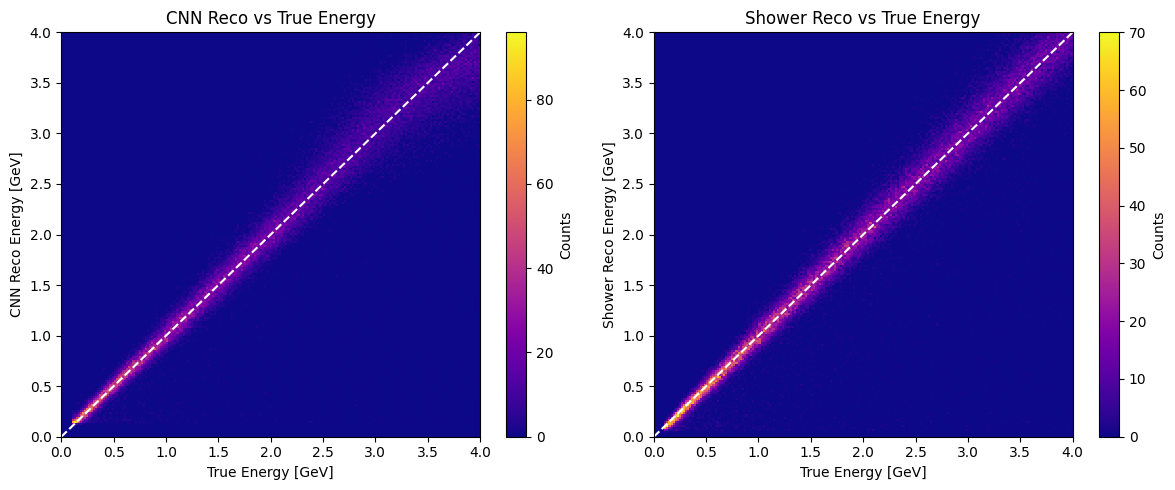

In [12]:
# lets evaluate with test dataset and compare to the showerE (conventional method)

recoE, thrownE, showerE = evaluate(model, test_loader, desc="Testing", returnShowerE = True)

import matplotlib.pyplot as plt

MIN_E = 0.0
MAX_E = 4.0
BINS = 200

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist2d(thrownE, recoE, bins=BINS, range=[[MIN_E, MAX_E], [MIN_E, MAX_E]], cmap="plasma")
plt.plot([MIN_E, MAX_E], [MIN_E, MAX_E], "w--")
plt.colorbar(label="Counts")
plt.xlabel("True Energy [GeV]")
plt.ylabel("CNN Reco Energy [GeV]")
plt.title("CNN Reco vs True Energy")
plt.subplot(1,2,2)
plt.hist2d(thrownE, showerE, bins=BINS, range=[[MIN_E, MAX_E], [MIN_E, MAX_E]], cmap="plasma")
plt.plot([MIN_E, MAX_E], [MIN_E, MAX_E], "w--")
plt.colorbar(label="Counts")
plt.xlabel("True Energy [GeV]")
plt.ylabel("Shower Reco Energy [GeV]")
plt.title("Shower Reco vs True Energy")
plt.tight_layout()
plt.show()


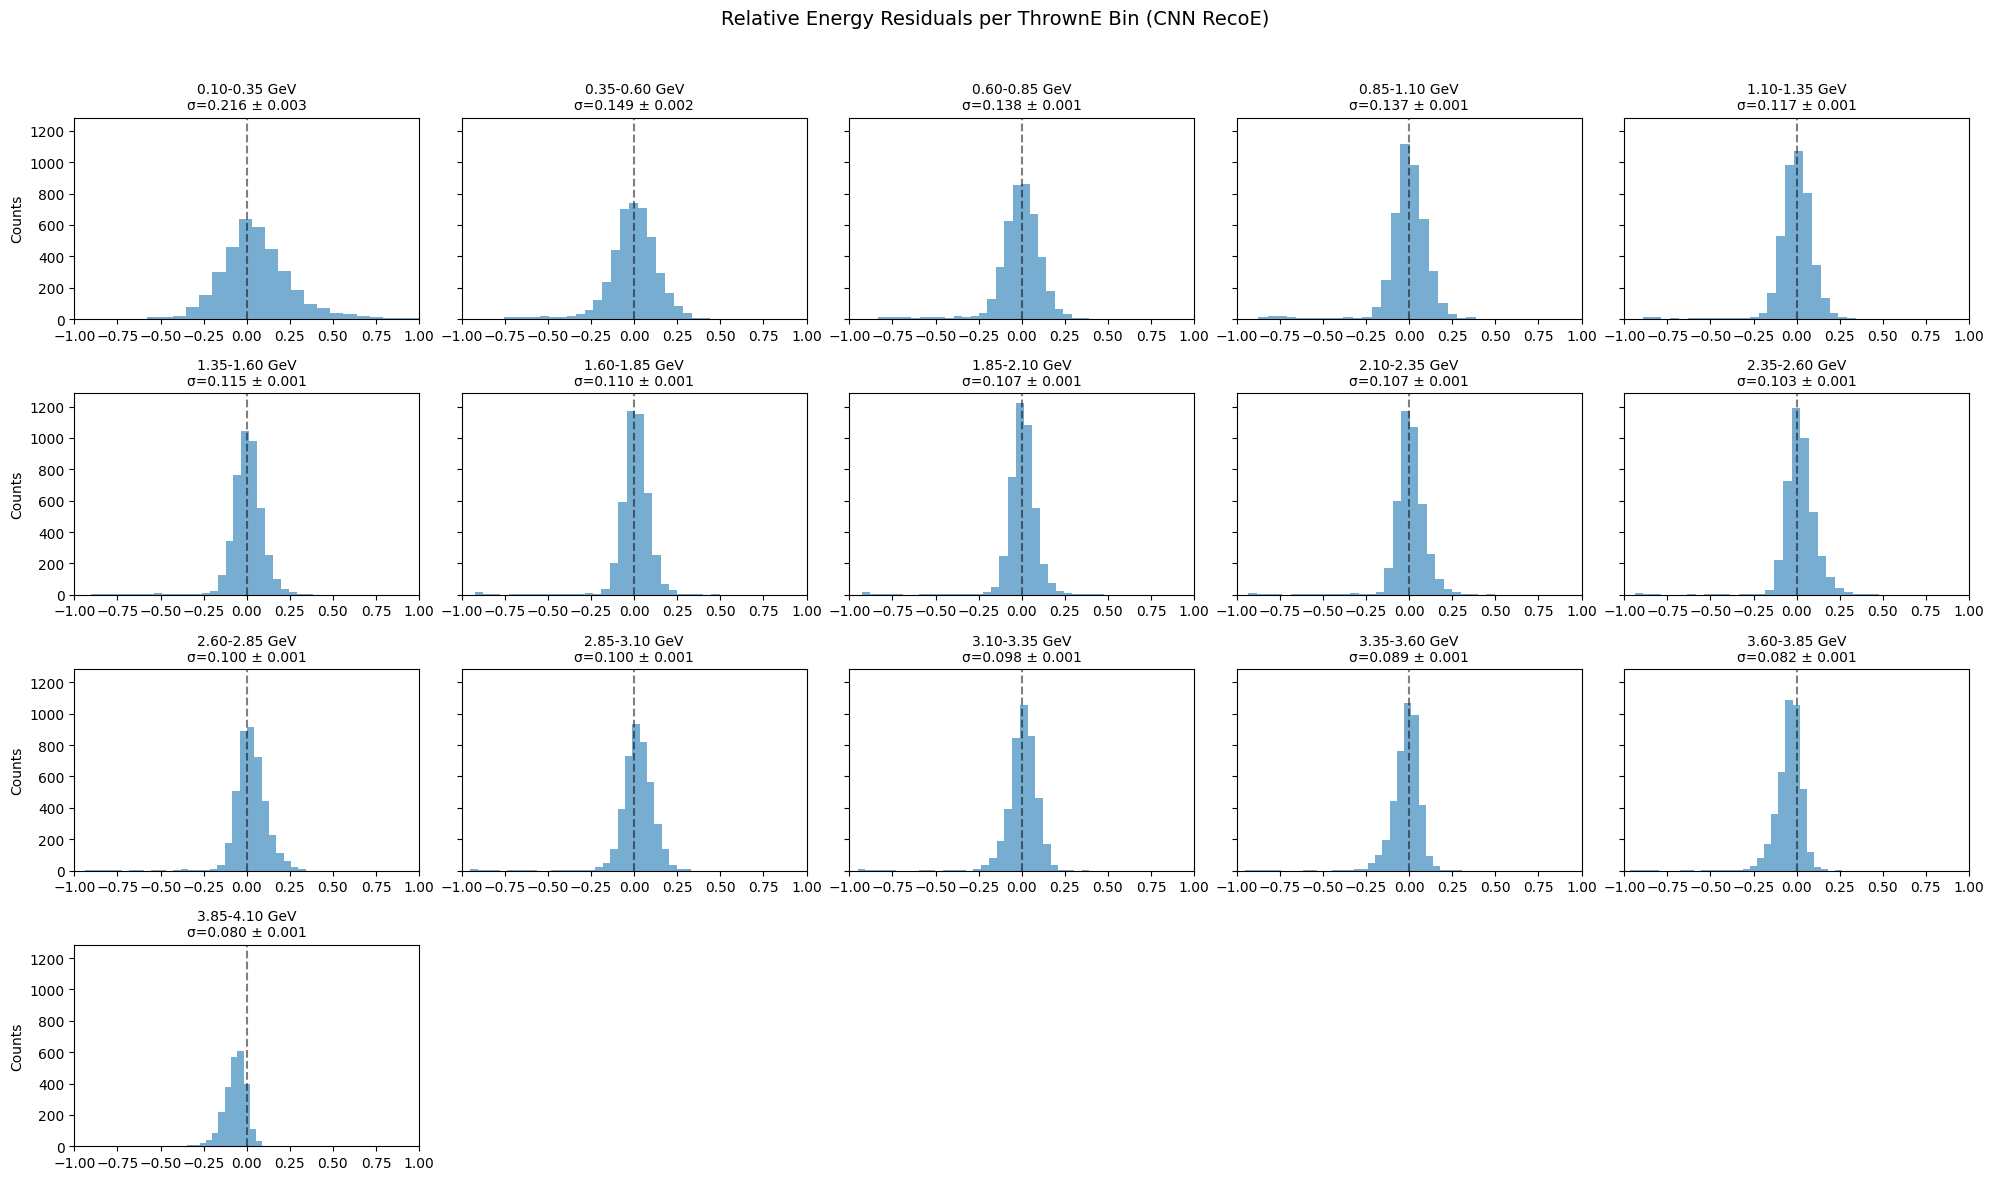

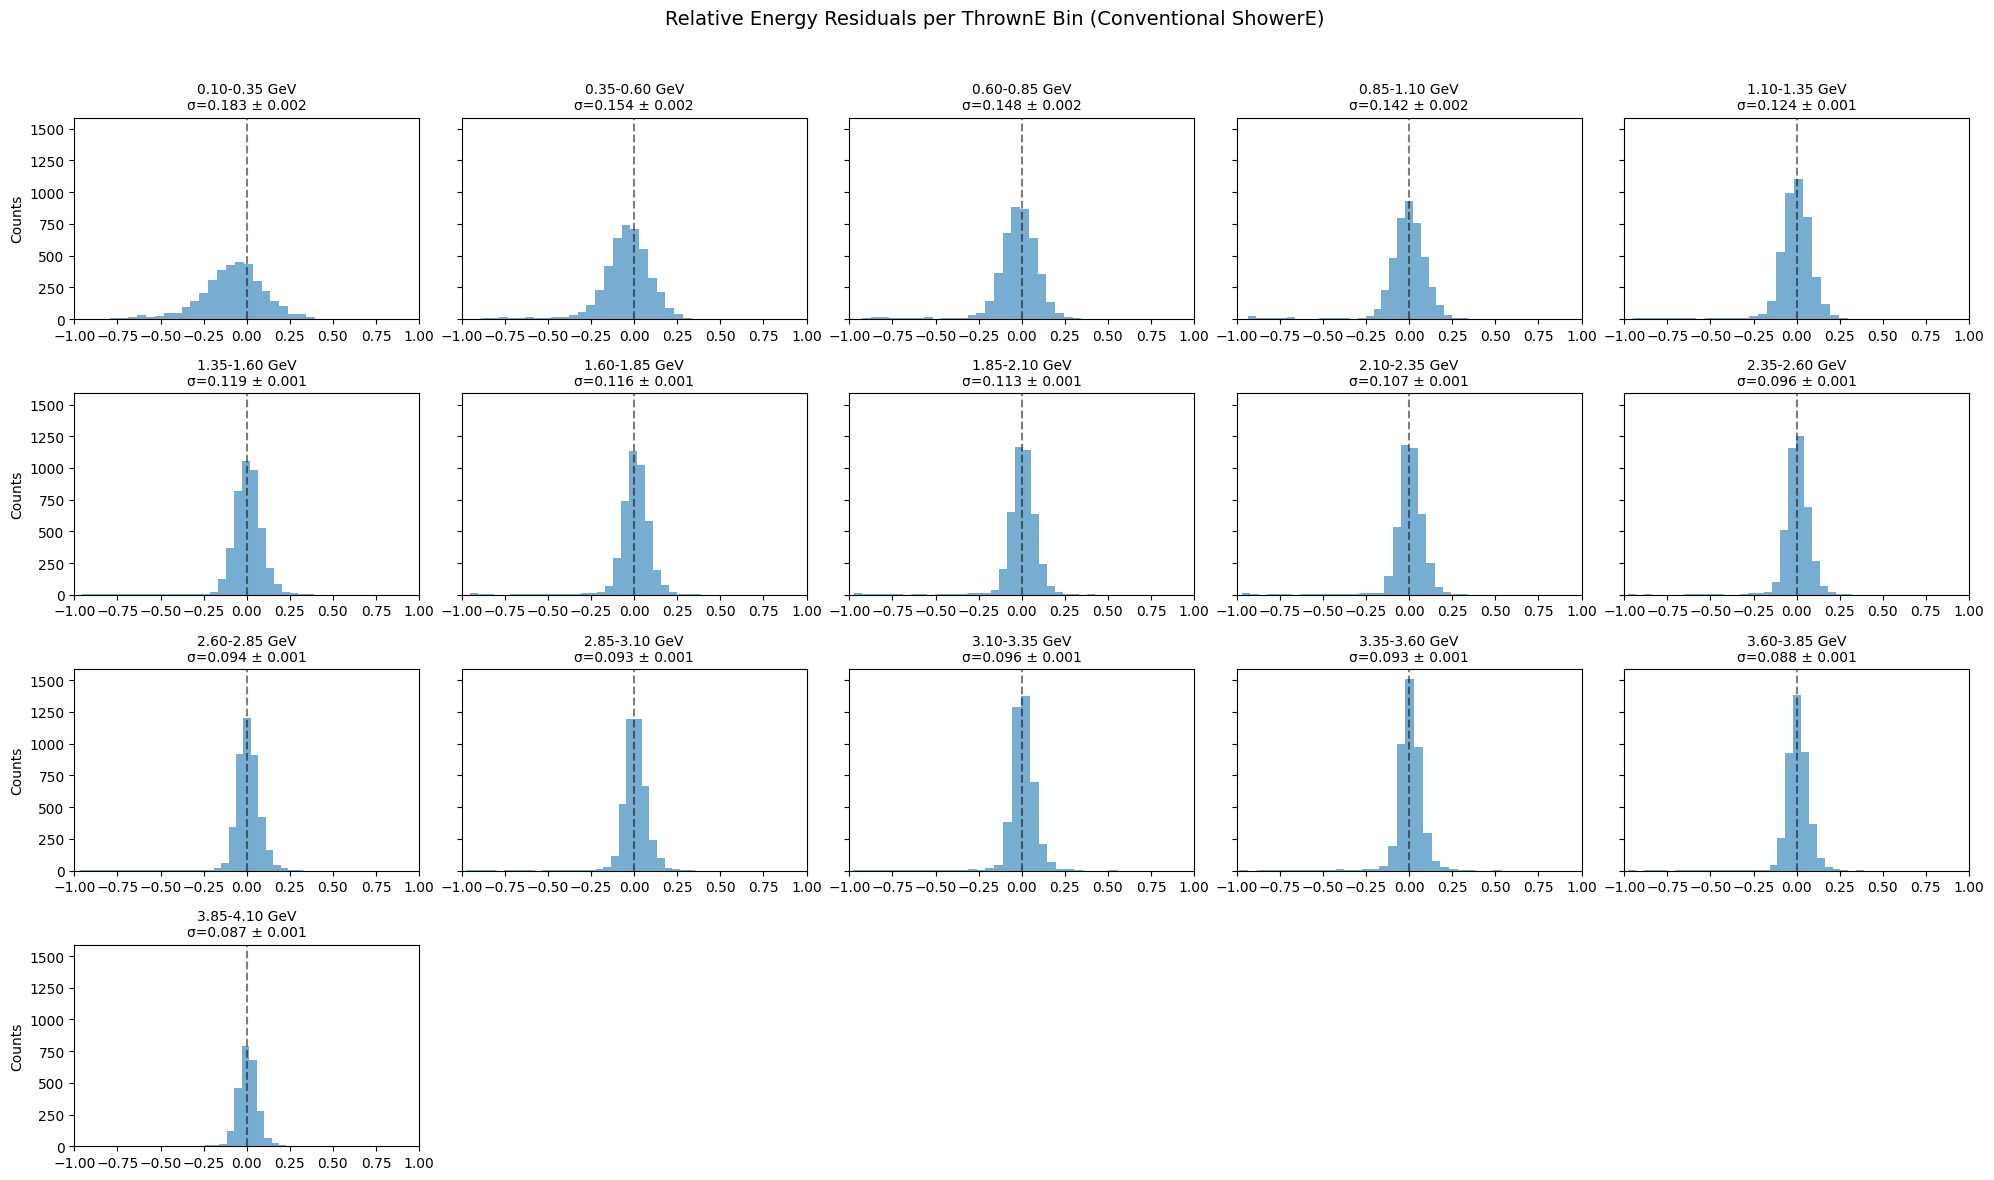

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Parameters and binning
# ----------------------------
bins = np.arange(0.1, 4.0 + 0.25, 0.25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# ----------------------------
# Function to compute sigma + plot histograms
# ----------------------------
def compute_and_plot(thrownE, testE, bins, label="recoE"):
    res_sigma, res_err, res_data = [], [], []

    for i in range(len(bins) - 1):
        mask = (thrownE >= bins[i]) & (thrownE < bins[i+1])
        if np.sum(mask) < 10:
            res_sigma.append(np.nan)
            res_err.append(np.nan)
            res_data.append(np.array([]))
            continue

        ratio = (testE[mask] - thrownE[mask]) / thrownE[mask]
        sigma = np.std(ratio)
        err = sigma / np.sqrt(2 * len(ratio))  # rough error estimate

        res_sigma.append(sigma)
        res_err.append(err)
        res_data.append(ratio)

    # ----------------------------
    # Plot subfigures of distributions
    # ----------------------------
    ncols = 5
    nrows = int(np.ceil(len(bins) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3*nrows), sharey=True)
    axes = axes.flatten()

    for i in range(len(bins)-1):
        ax = axes[i]
        data = res_data[i]
        if len(data) == 0:
            ax.axis("off")
            continue

        ax.hist(data, bins=30, histtype='stepfilled', alpha=0.6, color='C0')
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
        ax.set_xlim(-1, 1)
        ax.set_title(
            f"{bins[i]:.2f}-{bins[i+1]:.2f} GeV\n"
            f"σ={res_sigma[i]:.3f} ± {res_err[i]:.3f}",
            fontsize=10
        )
        if i % ncols == 0:
            ax.set_ylabel('Counts')

    for j in range(len(bins)-1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Relative Energy Residuals per ThrownE Bin ({label})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return np.array(res_sigma), np.array(res_err)


# ----------------------------
# Compute and visualize
# ----------------------------
sigma_reco, err_reco = compute_and_plot(thrownE, recoE, bins, label="CNN RecoE")
sigma_shwr, err_shwr = compute_and_plot(thrownE, showerE, bins, label="Conventional ShowerE")




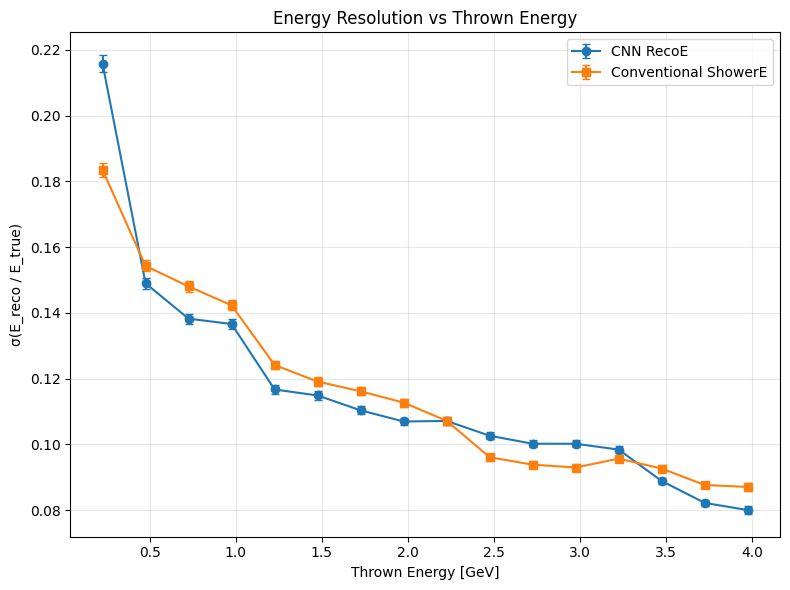

In [15]:
plt.figure(figsize=(8,6))
plt.errorbar(bin_centers, sigma_reco, yerr=err_reco, fmt='o-', label='CNN RecoE', capsize=3)
plt.errorbar(bin_centers, sigma_shwr, yerr=err_shwr, fmt='s-', label='Conventional ShowerE', capsize=3)

plt.xlabel('Thrown Energy [GeV]')
plt.ylabel('σ(E_reco / E_true)')
plt.title('Energy Resolution vs Thrown Energy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Exercise to Try Out

Now that we have successfully **regressed the shower energy** using the CNN model, you can take it a step further and test its **impact on physics reconstruction**.

### 🧩 Task Overview

Replace the conventional `showerE` with the **CNN-regressed energy (`recoE`)** in the **physics reaction reconstruction** chain.  
For example, in the `ω → π⁺π⁻π⁰ → π⁺π⁻γγ` channel, substitute the neutral shower energies with the regressed ones and observe the change in the reconstructed **ω invariant mass** distribution.

### 🧪 Goal

Check whether using the CNN-predicted energies leads to a **narrower ω mass peak**, indicating an **improvement in energy resolution** and hence **better physics fidelity**.

### ⚙️ Suggested Pipeline

1. **Photon Selection**
   - Identify neutral showers in each event.  
   - Use the trained CNN classifier to check if a neutral shower is a **good photon** candidate (i.e., not a hadronic splitoff).

2. **Energy Regression**
   - For the showers classified as good photons, replace the conventional `showerE` with the **CNN-regressed energy (`recoE`)**.

3. **Physics Reconstruction**
   - Reconstruct the π⁰ candidates and ω candidates using the new energies.  
   - Compare the resulting invariant mass spectra with the baseline (using `showerE`).

4. **Resolution Study**
   - Quantify the improvement by fitting the ω mass distribution with a Gaussian (and possible background function).  
   - Compare **σ(ω)** between the two cases.

### 🔍 Further Explorations

- Perform a more detailed **fit to the energy resolution curves**,  
  e.g. using a calorimeter-like parameterization:
$$
  \frac{\sigma_E}{E} = \frac{a}{\sqrt{E}} \oplus b
$$
  and study how tuning the CNN architecture or training data affects the stochastic and constant terms.

- Investigate how **different noise levels or thresholds** in the FCAL hit patterns influence the regression accuracy.

- Try **propagating the energy uncertainty** from the regression model into the invariant mass reconstruction and study how the **uncertainty on σ(ω)** evolves.

